In [57]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [58]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_dir = "/Users/michelangelozampieri/Desktop/TAMID-Group-New/data/sorted_data_output"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")
test_dir = os.path.join(data_dir, "test")

In [59]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [60]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_eval)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [61]:
class_names = train_dataset.classes
num_classes = len(class_names)

model = models.resnet50(pretrained=True)

model.fc = nn.Sequential(
    nn.Dropout(0.4),  # Regularization
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/michelangelozampieri/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 49.8MB/s]


In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

In [63]:
from tqdm import tqdm  # Import tqdm for progress bars

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm description with loss and accuracy
            pbar.set_postfix(loss=running_loss / (total / labels.size(0)), accuracy=100. * correct / total)

    # Update learning rate
    scheduler.step()
    # Calculate average loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%")


Training Epoch 1/10:   4%|▍         | 2/51 [01:30<37:00, 45.32s/batch, accuracy=37.5, loss=1.51]


KeyboardInterrupt: 

In [ ]:
# Testing phase
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Testing Epoch 10/10: 100%|██████████| 11/11 [05:19<00:00, 29.02s/batch, accuracy=90, loss=0.242]  

Epoch 10: Train Loss: 0.4271, Train Accuracy: 83.00%, Test Loss: 0.2652, Test Accuracy: 89.97%


In [ ]:
torch.save(model, 'resnet18_model.pth')

In [74]:
def predict_and_compare(image_path, model, class_names, transform, true_class=None, device='cuda'):
    from PIL import Image
    import matplotlib.pyplot as plt
    import torch

    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]

    # Display the image with prediction
    plt.imshow(image)
    title = f"Predicted: {predicted_class}"
    if true_class:
        title += f" | Actual: {true_class}"
    plt.title(title)
    plt.axis('off')
    plt.show()

    return predicted_class, true_class


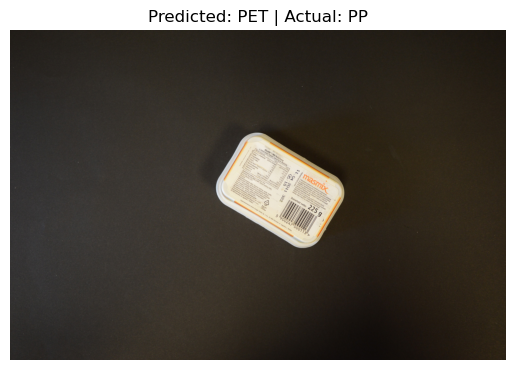

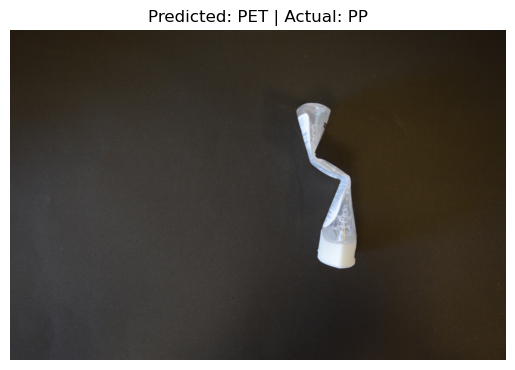

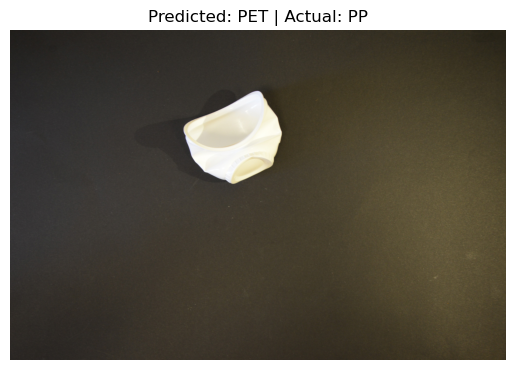

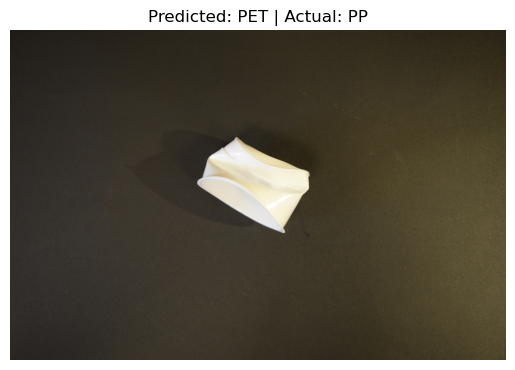

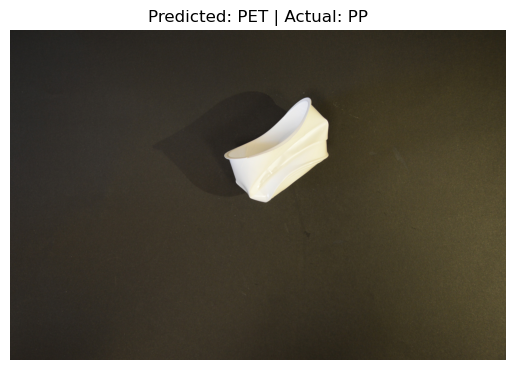

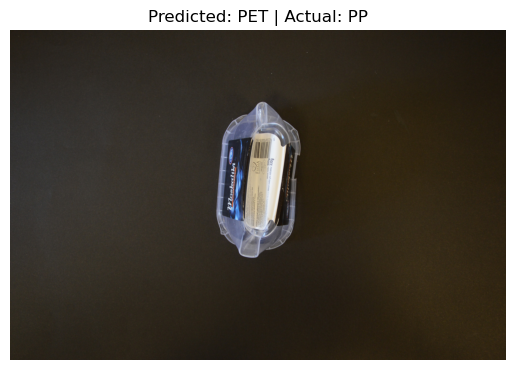

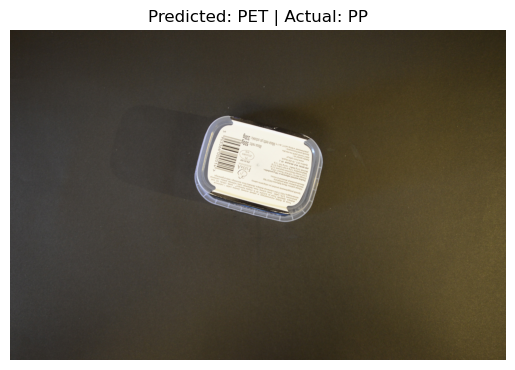

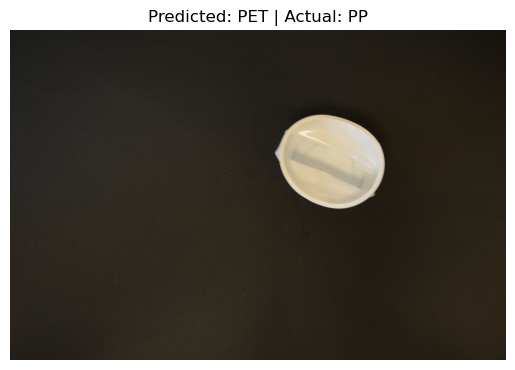

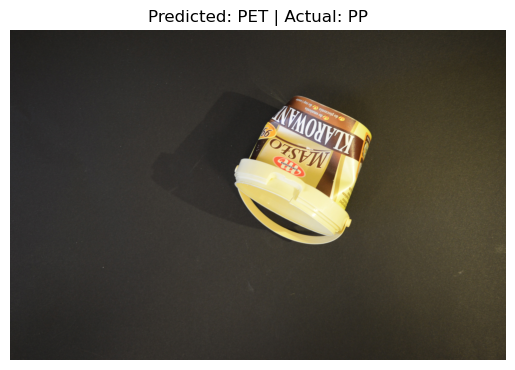

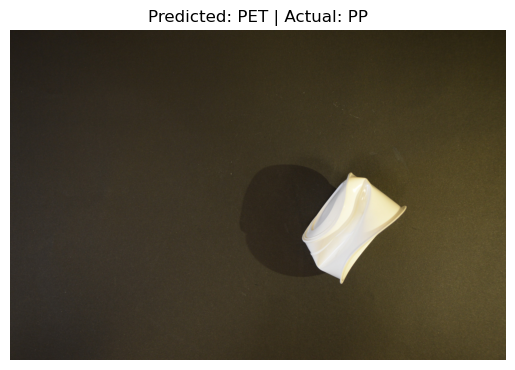

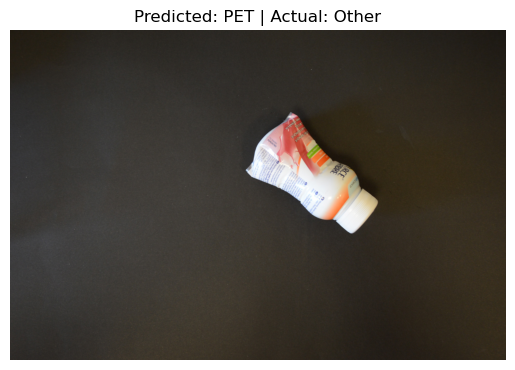

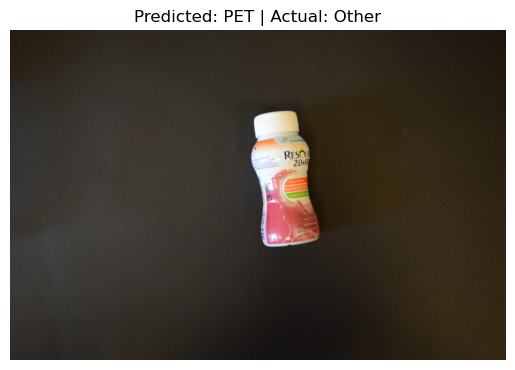

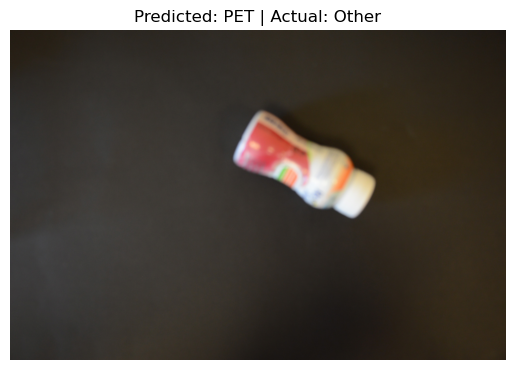

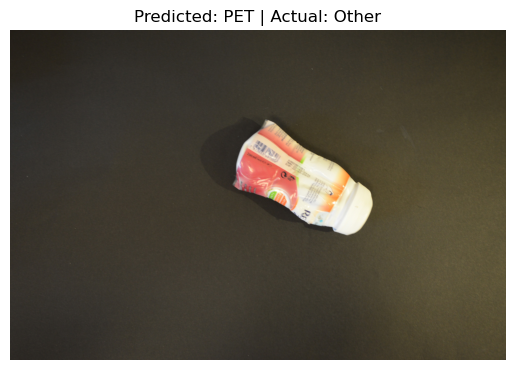

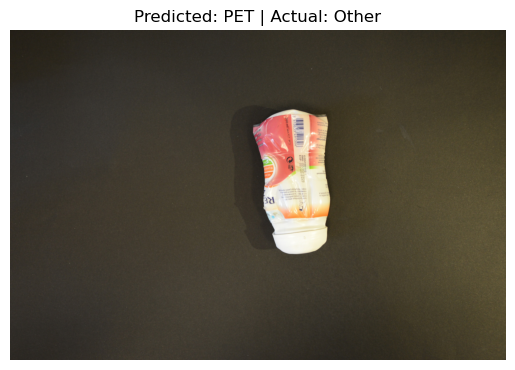

KeyboardInterrupt: 

In [75]:
for class_folder in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_folder)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path)[:10]:  # Only show 10 per class
            image_path = os.path.join(class_path, image_name)
            predict_and_compare(
                image_path=image_path,
                model=model,
                class_names=class_names,
                transform=transform_eval,
                true_class=class_folder,
                device=device
            )